<a href="https://colab.research.google.com/github/artu134/NN_Reinforsed/blob/master/LSTMv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/artu134/NN_Reinforsed.git

fatal: destination path 'NN_Reinforsed' already exists and is not an empty directory.


In [2]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout,CuDNNLSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
import re

# Imports for visualisations
from IPython.display import display
import keras.backend as K

In [3]:
from NN_Reinforsed.Generator.tidal_waves_gen import Generator
import datetime

coordinates = (37.7749,-122.4194)#(lat,lon) San Francisco
start_date =  datetime.datetime.strptime('2023-05-10','%Y-%m-%d') # Start date (YYYY-MM-DD)
days = 28*40

# Generate tidal data
generator = Generator(coordinates[0], coordinates[1])
tidal_data = generator.get_tidal_data(start_date, days)

In [4]:
tidal_force = list(map(lambda row:[row[1]],tidal_data))

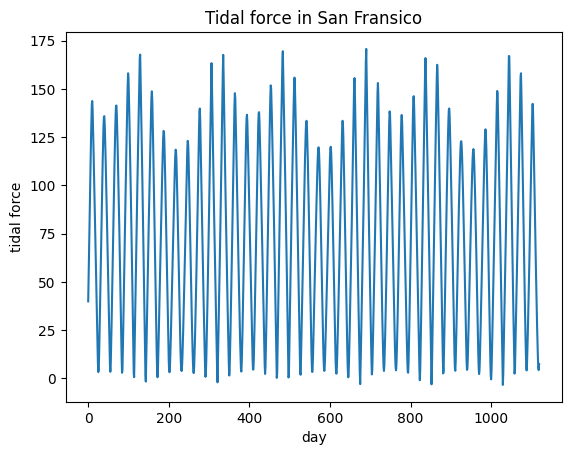

In [5]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.plot(tidal_force)
plt.title("Tidal force in San Fransico")
plt.xlabel("day")
plt.ylabel("tidal force")
plt.show()

Based on the chart we can see two different cycles. Shorter ones are moon phases, and bigger one is Sun phase. Also  there seems to be the third one because there is diffenece in Sun phases

In [131]:
window_size = 28*7
prediction_size = 28

# Data preprocessing

In [132]:
train_end = int(len(tidal_force)*0.6)
val_end = train_end + int(len(tidal_force)*0.2)
train_raw = tidal_force[:train_end]
val_raw = tidal_force[train_end:val_end]
test_raw = tidal_force[val_end:]

In [133]:
len(train_raw),len(val_raw),len(test_raw)

(672, 224, 224)

In [134]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

In [135]:
import numpy as np
training_set_raw_scaled = sc.fit_transform(train_raw)

X_train = []
y_train = []
for i in range(window_size, len(training_set_raw_scaled)):
    if i+prediction_size > len(training_set_raw_scaled):
      break
    X_train.append(training_set_raw_scaled[i-window_size:i])
    y_train.append(training_set_raw_scaled[i:i+prediction_size])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [136]:
X_train.shape, y_train.shape

((449, 196, 1), (449, 28, 1))

In [138]:
val_set_raw_scaled = sc.transform(val_raw)

X_val = []
y_val = []
for i in range(window_size, len(val_set_raw_scaled)):
    if i+prediction_size > len(val_set_raw_scaled):
      break
    X_val.append(val_set_raw_scaled[i-window_size:i])
    y_val.append(val_set_raw_scaled[i:i+prediction_size])
X_val, y_val = np.array(X_val), np.array(y_val)

X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))

In [139]:
X_val.shape, y_val.shape

((1, 196, 1), (1, 28, 1))

In [140]:
from keras.callbacks import ModelCheckpoint
# define the checkpoint
filepath="weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

# Model creation

In [141]:
regressor = Sequential()

regressor.add(LSTM(units = 512, 
                   activation='relu',
                   return_sequences = True, 
                   input_shape = (X_train.shape[1], 1)))
#regressor.add(Dropout(0.2))

#mdl.add(LSTM(64, return_sequences=True))
regressor.add(LSTM(64, return_sequences=False))

#regressor.add(LSTM(units = 50, return_sequences = True))
#regressor.add(Dropout(0.25))

#regressor.add(LSTM(units = 50, return_sequences = True))
#regressor.add(Dropout(0.25))

#regressor.add(LSTM(units = 50))   
#regressor.add(Dropout(0.25))

regressor.add(Dense(units = prediction_size,activation='linear'))

regressor.compile(optimizer = 'adam', loss = 'mean_absolute_error')
regressor.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 196, 512)          1052672   
                                                                 
 lstm_11 (LSTM)              (None, 64)                147712    
                                                                 
 dense_5 (Dense)             (None, 28)                1820      
                                                                 
Total params: 1,202,204
Trainable params: 1,202,204
Non-trainable params: 0
_________________________________________________________________


# Model Training

In [142]:
history = regressor.fit(X_train, y_train, validation_data=(X_val,y_val), epochs = 5, batch_size = 32, callbacks=callbacks_list)

Epoch 1/5
15/15 [==============================] - ETA: 0s - loss: 0.3311
Epoch 1: loss improved from inf to 0.33111, saving model to weights-improvement-01-0.3311.hdf5
15/15 [==============================] - 53s 3s/step - loss: 0.3311 - val_loss: 0.2524
Epoch 2/5
15/15 [==============================] - ETA: 0s - loss: 0.2367
Epoch 2: loss improved from 0.33111 to 0.23669, saving model to weights-improvement-02-0.2367.hdf5
15/15 [==============================] - 55s 4s/step - loss: 0.2367 - val_loss: 0.2299
Epoch 3/5
15/15 [==============================] - ETA: 0s - loss: 0.2234
Epoch 3: loss improved from 0.23669 to 0.22341, saving model to weights-improvement-03-0.2234.hdf5
15/15 [==============================] - 50s 3s/step - loss: 0.2234 - val_loss: 0.2145
Epoch 4/5
15/15 [==============================] - ETA: 0s - loss: 0.2044
Epoch 4: loss improved from 0.22341 to 0.20439, saving model to weights-improvement-04-0.2044.hdf5
15/15 [==============================] - 53s 3s/ste

Text(0.5, 1.0, 'Loss')

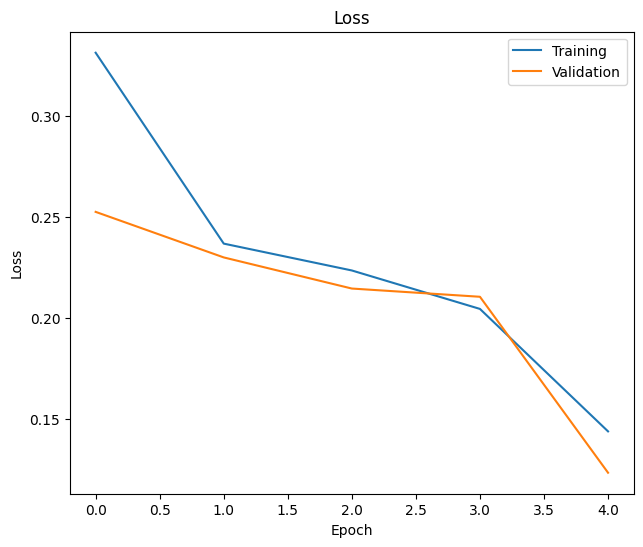

In [143]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss')

In [144]:
# 1st layer is LSTM layer with output shape (Batch_Size, 512)
lstm1 = regressor.layers[0]

# Get output from intermediate layer to visualize activations
attn_func1 = K.function(inputs = [lstm1.input],
           outputs = [lstm1.output]
          )
# 1st layer is LSTM layer with output shape (Batch_Size, 512)
lstm2 = regressor.layers[1]

# Get output from intermediate layer to visualize activations
attn_func2 = K.function(inputs = [lstm1.input],
           outputs = [lstm2.output]
          )

In [148]:
X_val.shape

(1, 196, 1)

In [149]:
X_val[0].shape

(196, 1)

In [178]:
l1 = attn_func1([X_val[0]])[0]
l1 = l1.reshape(l1.shape[0],l1.shape[-1])
l1.shape

(196, 512)

In [179]:
l2 = attn_func2([X_val[0]])[0]
l2.shape

(196, 64)

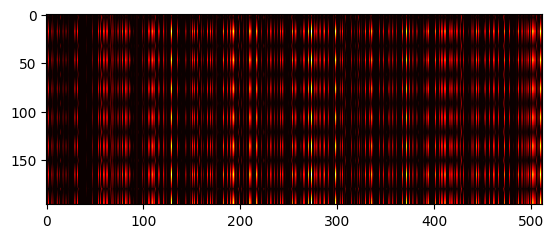

In [181]:
plt.imshow(l1, cmap='hot', interpolation='nearest')
plt.show()

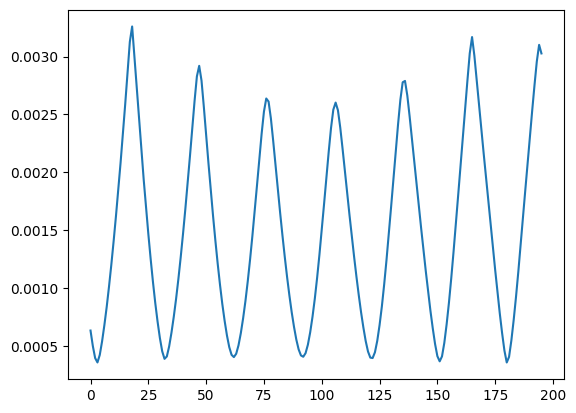

In [183]:
plt.plot(l1.mean(axis=1))
plt.show()

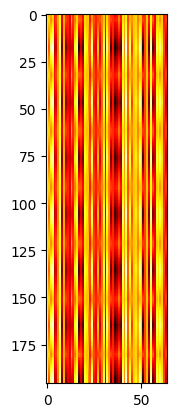

In [184]:
plt.imshow(l2, cmap='hot', interpolation='nearest')
plt.show()

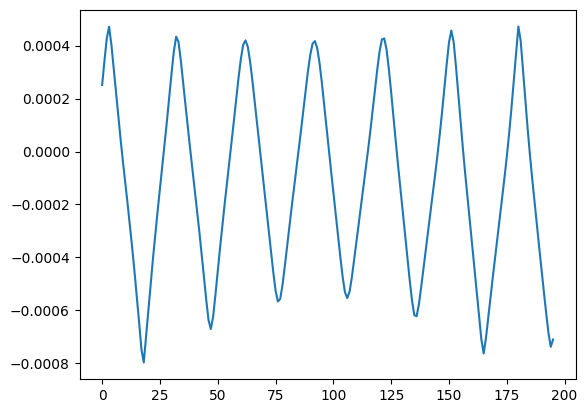

In [185]:
plt.plot(l2.mean(axis=1))
plt.show()

# Evaluation

In [156]:
train_predicted_norm = regressor.predict(X_train)
train_predicted = sc.inverse_transform(train_predicted_norm)
Y_train = sc.inverse_transform(y_train.reshape(-1,prediction_size))

15/15 [==============================] - 15s 1s/step


In [157]:
test_set_raw_scaled = np.concatenate([val_set_raw_scaled[-window_size:], sc.transform(test_raw)])
X_test = []
Y_test = []
for i in range(window_size, len(test_set_raw_scaled)-prediction_size):
    X_test.append(test_set_raw_scaled[i-window_size:i])
    Y_test.append(test_set_raw_scaled[i:i+prediction_size])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))



In [158]:
test_predicted_norm = regressor.predict(X_test)
test_predicted = sc.inverse_transform(test_predicted_norm)
Y_test = sc.inverse_transform(np.array(Y_test).reshape(-1,prediction_size))

7/7 [==============================] - 4s 548ms/step


In [159]:
from sklearn.metrics import mean_squared_error
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(Y_train, train_predicted))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(Y_test, test_predicted))
print('Test Score: %.2f RMSE' % (testScore))
#X_train, y_train

Train Score: 21.73 RMSE
Test Score: 21.29 RMSE


In [160]:
np.array(test_raw).shape

(224, 1)

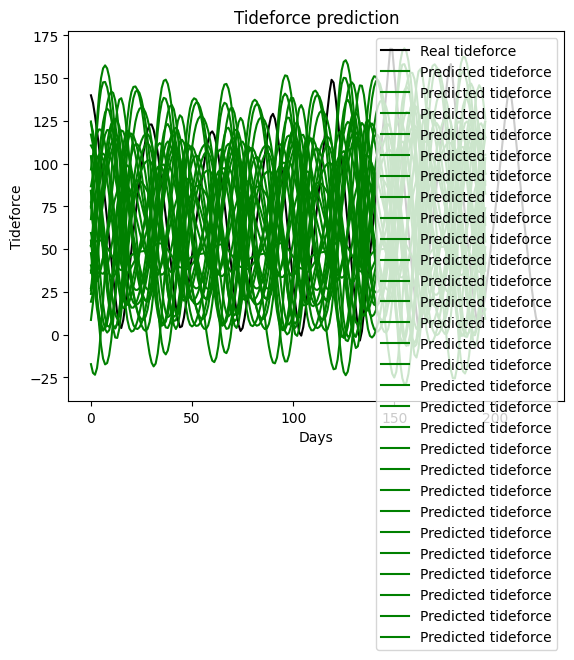

In [161]:
plt.plot(test_raw, color = 'black', label = 'Real tideforce')
plt.plot(test_predicted, color = 'green', label = 'Predicted tideforce')
plt.title('Tideforce prediction')
plt.xlabel('Days')
plt.ylabel('Tideforce')
plt.legend()
plt.show()

In [162]:
input_window = val_set_raw_scaled[-window_size:].tolist()
predictions = []
for val in test_raw:
  input = np.array([input_window],dtype=np.float64)
  predicted_norm = regressor.predict(input)
  predicted = sc.inverse_transform(predicted_norm)
  val=predicted.reshape((28))
  predictions.append(val)
  
  input_window.append(val)
  input_window.pop(0)
  break

1/1 [==============================] - 0s 97ms/step


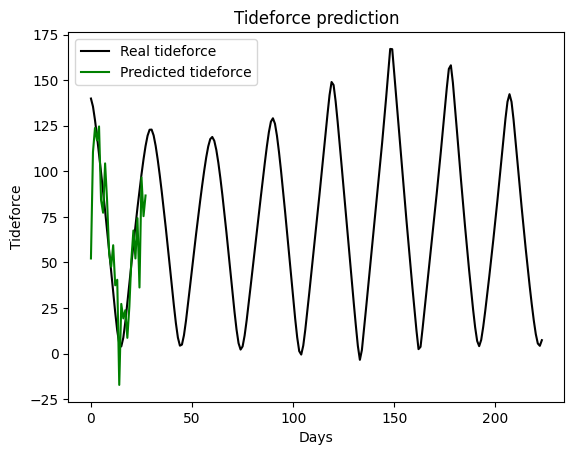

In [163]:
plt.plot(test_raw, color = 'black', label = 'Real tideforce')
plt.plot(predictions[0], color = 'green', label = 'Predicted tideforce')
plt.title('Tideforce prediction')
plt.xlabel('Days')
plt.ylabel('Tideforce')
plt.legend()
plt.show()